In [2]:
%load_ext autoreload
import glob
import nibabel
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed

from IPython.core.debugger import set_trace

import os
import shutil
import pickle

import torch
import torch.nn.functional as F

from utils import create_dicts, normalize, load, video, video_comparison

from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera

SEED = 42
%autoreload 2

# Affine transform

In [3]:
affine_pth = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'

In [5]:
matrix = h5py.File(affine_pth, "r")

In [15]:
matrix_tg = matrix['TransformGroup']

In [29]:
for k,v in matrix_tg.items():
    print('----------------')
    print(k,v, 'has:...')
    
    for k_,v_ in v.items():
        print(k_,v_)
        

----------------
0 <HDF5 group "/TransformGroup/0" (1 members)> has:...
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">
----------------
1 <HDF5 group "/TransformGroup/1" (3 members)> has:...
TransformFixedParameters <HDF5 dataset "TransformFixedParameters": shape (3,), type "<f8">
TransformParameters <HDF5 dataset "TransformParameters": shape (12,), type "<f4">
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">
----------------
2 <HDF5 group "/TransformGroup/2" (3 members)> has:...
TransformFixedParameters <HDF5 dataset "TransformFixedParameters": shape (18,), type "<f8">
TransformParameters <HDF5 dataset "TransformParameters": shape (25590063,), type "<f4">
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">


In [6]:
matrix.create_dataset()

<HDF5 file "sub-43_acq-T1MprageSagP2Iso_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5" (mode r)>

In [6]:
brain_path_orig = '/nfs/garfield/ibulygin/preprocessed_data_v2/fmriprep/sub-n8/anat/'
brain_path_mn152 = '/nfs/garfield/ibulygin/preprocessed_data_v2/fmriprep/sub-n10/anat/sub-n10_acq-T1MprageSagP2IsoOrig_desc-preproc_T1w.nii.gz'

brain_sample = nibabel.load(brain_path).get_fdata()

In [ ]:
ls -la 

In [4]:
brain_sample.shape

(192, 352, 352)

# Loading data

In [24]:
labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()
nonsingle_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'43','n27','33','37', '9', 'n31',
                 'n30', 'n10', 'n8', '47', '6',
                 '25', '12'}.union(nonsingle_component_keys)

In [21]:
root = '/media/tom/ibulygin/fcd_data/radiologist/'
root_label = os.path.join(root, 'label')

feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii.gz'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
      'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
      'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=lambda x: x.split('.')[0],
                         broken_labels={})

No curv for 55
No curv for 68NS
No curv for n35
No curv for n75
No curv for n20
No curv for n49
No curv for n68
No curv for 81NS
No curv for n42
No curv for n76
No curv for 85NS
No curv for 29
No curv for n37
No curv for G150
No curv for 78NS
No curv for 86NS
No curv for n53
No curv for G180
No curv for n84
No curv for n69
No curv for n65
No curv for 59
No bT1 for 27
No curv for n38
No curv for n60
No curv for 79NS
No curv for 73NS
No curv for n62
No curv for 63NS
No curv for 53
No curv for n40
No curv for 87NS
No curv for n71
No curv for 26
No curv for n44
No curv for 80NS
No curv for n23
No curv for 72NS
No curv for n56
No curv for n73
No curv for n72
No bT1 for n33
No curv for 74NS
No curv for G184
No curv for n54
No curv for n3
No curv for n59
No curv for n52
No curv for G015
No curv for n47
No curv for n55
No curv for n48
No curv for n83
No curv for 62NS
No curv for n39
No curv for 69NS
No curv for n82
No curv for 61
No curv for 50
No curv for n70
No curv for n58
No curv for 57
No

In [32]:
all_labels = set(paths_dict.keys()) - set(labels_broken)
test_labels = ['n15', '30', '49', '41', 'n11', '10', 'n5']
train_labels = sorted(all_labels - set(test_labels))

for label in test_labels:
    assert label in all_labels

In [34]:
metadata_path = 'metadata/metadata_fcd'
metadata = {'train':train_labels,
            'test':test_labels}
np.save(metadata_path, metadata)

In [59]:
def make_tensor(root, name, pdict, save=True):
    
    data_dict = load(pdict)
    
    ################
    # MAKE TENSORS #
    ################
    
    mask = data_dict['mask'] > 0 # it should be bool!

    label = data_dict['label'] * mask.astype(int)
    label = np.array(label) > 0
    
    mask_tensor_torch = torch.tensor(mask, dtype=torch.float32)
    label_tensor_torch = torch.tensor(label, dtype=torch.float32)
    
    torch_tensor = {'mask':mask_tensor_torch,
                    'label':label_tensor_torch}
    
    for k,v in data_dict.items():
        if not k in ['mask', 'label']:
            data = normalize(v, mask)
            data_torch = torch.tensor(data, dtype=torch.float32)
            torch_tensor[k] = data_torch
    if save:
        torch.save(torch_tensor, os.path.join(root, f'tensor_{name}'))
    
    return torch_tensor

In [68]:
%%time
tensor = make_tensor('./', '43', paths_dict['43'], save=False)

CPU times: user 45 s, sys: 6.04 s, total: 51.1 s
Wall time: 13.1 s


In [69]:
for k,v in tensor.items():
    print(k,v.shape, v.max(), v.min())

mask torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
label torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
curv torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
sulc torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
thickness torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
bT1 torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
bT2 torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
T1w torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
T2 torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
CSF torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
GM torch.Size([241, 336, 283]) tensor(1.) tensor(0.)
WM torch.Size([241, 336, 283]) tensor(1.) tensor(0.)


In [70]:
brain = tensor['T1w'].numpy()

In [1]:
tensor.keys()

NameError: name 'tensor' is not defined

In [71]:
plt.ioff()
camera = video_comparison([t.numpy() for t in tensor.values()],
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

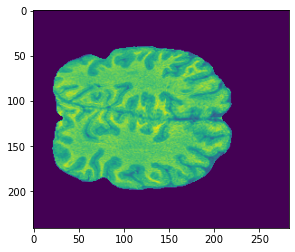

In [73]:
plt.figure()
plt.imshow(brain[:,100,:])
plt.show()

In [74]:
tensors_root = '/media/tom/ibulygin/fcd_data/tensors'

In [75]:
_ = Parallel(n_jobs=N_CPU//2)(delayed(make_tensor)(tensors_root, 
                                             k, v) \
                        for k,v in tqdm(paths_dict.items()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [1:59:30<00:00, 89.63s/it]


In [46]:
tensor = torch.load(os.path.join(tensors_root, 'tensor_43'))

In [47]:
for k,v in tensor.items():
    print(k, v.max(), v.min(), v.shape)

mask tensor(1.) tensor(0.) torch.Size([241, 336, 283])
label tensor(1.) tensor(0.) torch.Size([241, 336, 283])
curv tensor(1.) tensor(0.) torch.Size([241, 336, 283])
sulc tensor(1.) tensor(0.) torch.Size([241, 336, 283])
thickness tensor(1.) tensor(0.) torch.Size([241, 336, 283])
bT1 tensor(1.) tensor(0.) torch.Size([241, 336, 283])
bT2 tensor(1.) tensor(0.) torch.Size([241, 336, 283])
T1w tensor(1.) tensor(0.) torch.Size([241, 336, 283])
T2 tensor(1.) tensor(0.) torch.Size([241, 336, 283])
CSF tensor(1.) tensor(0.) torch.Size([241, 336, 283])
GM tensor(1.) tensor(0.) torch.Size([241, 336, 283])
WM tensor(1.) tensor(0.) torch.Size([241, 336, 283])


# Metadata

In [48]:
metadata_path = '/nfs/garfield/ibulygin/metadata_v2'
train_keys, test_keys = train_test_split(list(paths_dict.keys()), test_size=0.1, random_state=SEED)
metadata = {'train':train_keys,
            'test':test_keys,
            'seed':SEED}

np.save(metadata_path, metadata)

In [49]:
metadata = np.load(f'{metadata_path}.npy',allow_pickle=True).item()

In [50]:
len(metadata['train'])

56

# Yarkin data (draft)

In [14]:
# root = '../fcd_data/yarkin_06dec2021'

In [16]:
# ls -la ../fcd_data/yarkin_06dec2021/sub-9/ # sub-17_MNI152NLint2_brain-Flair.nii

total 1175352
drwxr-xr-x  2 ibulygin users      4096 дек  6 15:33 ./
drwxrwxrwx 92 ibulygin users      4096 дек  6 15:47 ../
-rw-r--r--  1 ibulygin users 183330016 дек  6 15:33 c1sub-9_MNI152NLint2_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c1sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c2sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c3sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  91226464 дек  6 15:33 hrsub-9_brain-Flair_mask.nii
-rw-r--r--  1 ibulygin users    256056 дек  6 15:33 hrsub-9_brain-Flair_mask.nii.gz
-rw-r--r--  1 ibulygin users 182452576 дек  6 15:33 hrsub-9_brain-Flair.nii
-rw-r--r--  1 ibulygin users  21892116 дек  6 15:33 hrsub-9_brain-Flair.nii.gz
-rw-r--r--  1 ibulygin users 182452576 дек  6 15:33 msub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users   2371932 дек  6 15:33 norm_and_wgsub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users   2371932 дек  6 15:33 skullstriped-sub-9_s

c1sub-9_MNI152NLint2_struct-Flair.nii - **asym**  
c1sub-9_struct-Flair.nii - **SYM!**  
c2sub-9_struct-Flair.nii - **SYM!**  
c3sub-9_struct-Flair.nii - **SYM!**  
hrsub-9_brain-Flair_mask.nii - **SYM!**  
hrsub-9_brain-Flair_mask.nii.gz - **SYM!**  
hrsub-9_brain-Flair.nii - **checK IT!! SYM!**  
hrsub-9_brain-Flair.nii.gz - **SYM!**  
msub-9_struct-Flair.nii - **SYM!, tissue**  
norm_and_wgsub-9_struct-Flair.nii - **SYM, lowdim**  
skullstriped-sub-9_struct-Flair.nii - **SYM, lowdim**  
sub-9_MNI152NLint2_brain-Flair.nii - **BRAIN, 1X1, ASYM**    
sub-9_struct-Flair.nii - **ASYM**  
sub-9_struct-Flair_seg_inv_sn.mat  
sub-9_struct-Flair_seg_sn.mat  
wc1_or_wc2sub-9_struct-Flair.nii - **SYM lowdim**  
wc1sub-9_struct-Flair.nii - **SYM lowdim**  
wc2sub-9_struct-Flair.nii - **SYM lowdim**    
wc3sub-9_struct-Flair.nii - **SYM lowdim**    
wmsub-9_struct-Flair.nii - **SYM lowdim tissues**   

In [82]:
# brain = nibabel.load('../fcd_data/yarkin_06dec2021/sub-9/sub-9_MNI152NLint2_brain-Flair.nii').get_fdata()
# brain = nibabel.load('../fcd_data/yarkin_06dec2021/sub-9/hrsub-9_brain-Flair.nii').get_fdata()